In [87]:
import os
import cv2
import PIL
import math
import skimage
import albumentations
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import datetime

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

from text2embed import Text2Embed
from utils import seeding, create_dir, print_and_save, shuffling, epoch_time, calculate_metrics, label_dictionary, mask_to_bbox
from model import TGAPolypSeg
from metrics import DiceLoss, DiceBCELoss, MultiClassBCE
from albumentations import  HorizontalFlip, VerticalFlip, ColorJitter, Affine, Resize, Compose

In [88]:
data_dir = os.path.join('C:/Users/ZAKAR/Documents/GitHub/AIFFEL/Exploration/DLthon/data/')

train_dir = os.path.join(data_dir + 'train')
test_dir = os.path.join(data_dir + 'test')
class_dict_dir = data_dir + 'class_dict.csv'
metadata_dir = data_dir + 'metadata.csv'

In [89]:
def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭(default)
                    VerticalFlip(p=0.5),      # 50%의 확률로 수직대칭(default)
                    ColorJitter(
                        brightness=(0.6, 1.6),# 밝기
                        contrast=0.2,         # 대비 
                        saturation=0.1,       # 채도
                        hue=0.01,             # 색상
                        always_apply=True,
                        ),
                    Affine(
                        rotate=(-180, 180),   # 회전
                        translate_percent=(-0.125, 0.125),  # 사진 이동 비율 // (최소비율 , 최대비율)로 지정하여 사용가능
                        # tranlate_px=[-0.125, 0.125],        # 사진 이동 픽셀 // (최소 픽셀, 최대 픽셀) 
                        # 이거 둘중에 뭐지
                        scale=(0.5, 1.5),     # ("zoom" in/out)
                        shear=(-22.5, 22),    # (move one side of the image, turning a square into a trapezoid)
                                              # 영상의 한쪽을 이동하여 사각형을 사다리꼴로 만듦(기울임)
                        always_apply=True,
                        # interpolation=1,
                        # border_mode=4,
                        # mode='reflect',  # border 처리 방식
                        ),
                    Resize(              # 입력이미지를 256X256로 resize (모델에 맞게 설정)
                        width=256,
                        height=256
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 256X256로 resize만 수행 (모델에 맞게 설정)
                Resize(
                    width=256,
                    height=256
                    )
                ])

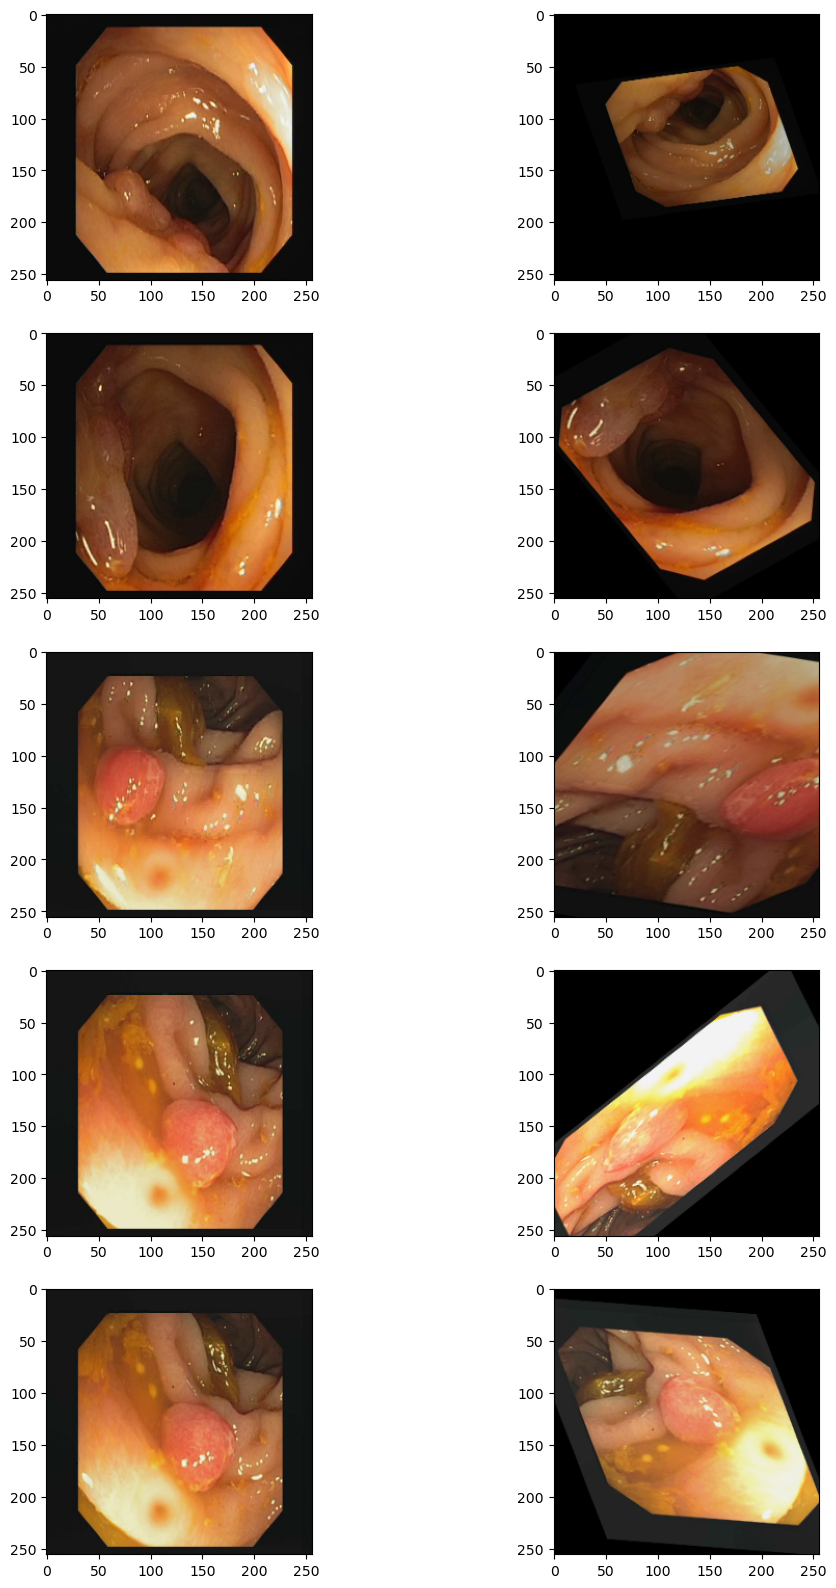

In [90]:
augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(train_dir, "PNG",'Originals', "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

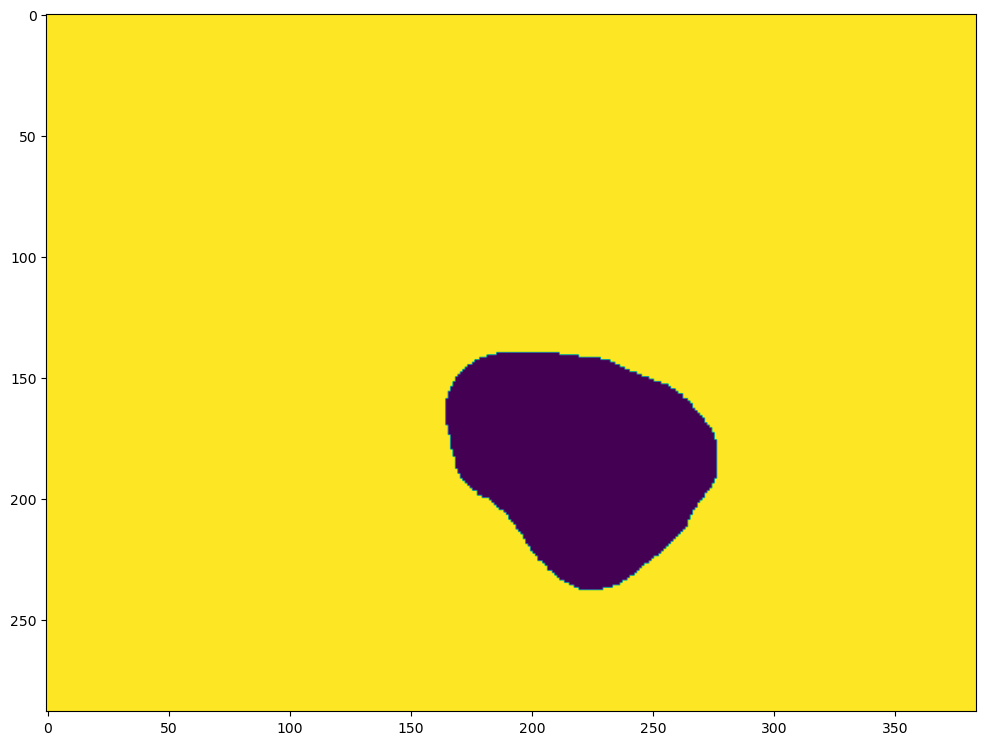

In [91]:
label_test = glob(os.path.join(train_dir, "PNG", 'GroundTruth', "*.png"))

plt.figure(figsize=(12, 20))
i=3
img = imread(label_test[i], as_gray=True) 
_output = (img==0).astype(np.uint8)*1

plt.imshow(_output)  
  
plt.show()

In [92]:
class Generator(tf.keras.utils.Sequence):

    def __init__(self, dir_path, batch_size=128, img_size=(256, 256, 3), 
                 output_size=(256, 256), is_train=True, augmentation=None):
        self.dir_path = dir_path 
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation    # 적용할 augmentation 함수를 인자로 받음
        self.img_size = img_size            # preprocess에 사용할 input image size
        self.output_size = output_size      # ground_truth를 만들기 위한 size

        # load_dataset()을 통해서 dataset의 directory path에서 라벨과 이미지를 확인
        self.data = self.load_dataset()

    def load_dataset(self):
    # test set을 분리해서 load
        png_input_images = glob(os.path.join(self.dir_path + "/PNG" + '/Originals' + "/*.png"))
        png_label_images = glob(os.path.join(self.dir_path + "/PNG" + '/GroundTruth' + "/*.png"))
        input_images = png_input_images
        label_images = png_label_images
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length
        # 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # input, output 만듦
        # input : resize및 augmentation이 적용된 input image
        # output : semantic label
        batch_data = self.data[
                            index*self.batch_size:
                            (index + 1)*self.batch_size
                            ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
            
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            #여기수정
            _output = imread(output_path, as_gray=True)
            _output = (_output==0).astype(np.uint8)*1
            data = {"image": _input,"mask": _output,}
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수
        # 학습중인 경우에 순서를 random shuffle하도록 적용
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [93]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = Generator(
    train_dir, 
    augmentation=augmentation,
)

validation_generator = Generator(
    train_dir
)

test_generator = Generator(
    test_dir, 
    augmentation=test_preproc,
    is_train=False
)

In [94]:
def load_image(input_img_path, output_img_path, img_size=(256, 256), output_size=(256, 256)):
    input_img = tf.io.read_file(input_img_path)
    input_img = tf.image.decode_png(input_img, channels=3)
    input_img = tf.image.resize(input_img, img_size)
    input_img = input_img / 255.0

    output_img = tf.io.read_file(output_img_path)
    output_img = tf.image.decode_png(output_img, channels=1)
    output_img = tf.image.resize(output_img, output_size)
    output_img = output_img / 255.0

    return input_img, output_img

def create_dataset(dir_path, img_size=(256, 256), output_size=(256, 256), batch_size=128):
    png_input_images = glob(os.path.join(dir_path + "/PNG" + '/Originals' + "/*.png"))
    png_label_images = glob(os.path.join(dir_path + "/PNG" + '/GroundTruth' + "/*.png"))
    input_images = png_input_images
    label_images = png_label_images
    input_images.sort()
    label_images.sort()

    assert len(input_images) == len(label_images)

    dataset = tf.data.Dataset.from_tensor_slices((input_images, label_images))
    dataset = dataset.map(lambda x, y: load_image(x, y, img_size, output_size))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [95]:
train_dataset = create_dataset(train_dir)

In [96]:
@tf.function
def train_step(model, optimizer, loss_fn, x, l, y1, y2, y3):
    with tf.GradientTape() as tape:
        p1, p2, p3 = model(x, l)
        p2 = tf.nn.softmax(p2, axis=1)
        p3 = tf.nn.softmax(p3, axis=1)

        loss1 = loss_fn[0](y1, p1)
        loss2 = loss_fn[1](y2, p2)
        loss3 = loss_fn[2](y3, p3)
        loss = loss1 + loss2 + loss3

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

def train(model, loader, optimizer, loss_fn):
    epoch_loss = 0.0
    epoch_jac = 0.0
    epoch_f1 = 0.0
    epoch_recall = 0.0
    epoch_precision = 0.0

    
    for i, ((x, l), (y1, y2, y3)) in enumerate(loader):
        x = tf.cast(x, tf.float32)
        l = tf.cast(l, tf.float32)
        y1 = tf.cast(y1, tf.float32)
        y2 = tf.cast(y2, tf.int32)
        y3 = tf.cast(y3, tf.int32)

        loss = train_step(model, optimizer, loss_fn, x, l, y1, y2, y3)
        epoch_loss += loss

        """ Calculate the metrics """
        batch_jac = []
        batch_f1 = []
        batch_recall = []
        batch_precision = []

        for yt, yp in zip(y1, p1):
            score = calculate_metrics(yt, yp)
            batch_jac.append(score[0])
            batch_f1.append(score[1])
            batch_recall.append(score[2])
            batch_precision.append(score[3])

        epoch_jac += np.mean(batch_jac)
        epoch_f1 += np.mean(batch_f1)
        epoch_recall += np.mean(batch_recall)
        epoch_precision += np.mean(batch_precision)

    epoch_loss = epoch_loss/len(loader)
    epoch_jac = epoch_jac/len(loader)
    epoch_f1 = epoch_f1/len(loader)
    epoch_recall = epoch_recall/len(loader)
    epoch_precision = epoch_precision/len(loader)

    return epoch_loss, [epoch_jac, epoch_f1, epoch_recall, epoch_precision]

In [97]:
def evaluate(model, loader, loss_fn):
    model.evaluate()

    epoch_loss = 0.0
    epoch_jac = 0.0
    epoch_f1 = 0.0
    epoch_recall = 0.0
    epoch_precision = 0.0

    for i, (x, y) in enumerate(loader):
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        y = tf.convert_to_tensor(y, dtype=tf.float32)

        p = model(x)
        p = tf.nn.softmax(p, axis=1)

        loss = loss_fn(y, p)
        epoch_loss += loss.numpy()

        """ Calculate the metrics """
        batch_jac = []
        batch_f1 = []
        batch_recall = []
        batch_precision = []

        for yt, yp in zip(y, p):
            score = calculate_metrics(yt, yp)
            batch_jac.append(score[0])
            batch_f1.append(score[1])
            batch_recall.append(score[2])
            batch_precision.append(score[3])

        epoch_jac += np.mean(batch_jac)
        epoch_f1 += np.mean(batch_f1)
        epoch_recall += np.mean(batch_recall)
        epoch_precision += np.mean(batch_precision)

    epoch_loss = epoch_loss / len(loader)
    epoch_jac = epoch_jac / len(loader)
    epoch_f1 = epoch_f1 / len(loader)
    epoch_recall = epoch_recall / len(loader)
    epoch_precision = epoch_precision / len(loader)

    return epoch_loss, [epoch_jac, epoch_f1, epoch_recall, epoch_precision]

if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Directories """
    create_dir("files")

    """ Training logfile """
    train_log_path = "files/train_log.txt"
    if os.path.exists(train_log_path):
        print("Log file exists")
    else:
        train_log = open("files/train_log.txt", "w")
        train_log.write("\n")
        train_log.close()

    """ Record Date & Time """
    datetime_object = str(datetime.datetime.now())
    print_and_save(train_log_path, datetime_object)
    print("")

    """ Hyperparameters """
    image_size = 256
    size = (image_size, image_size)
    batch_size = 16
    num_epochs = 500
    lr = 1e-4
    early_stopping_patience = 50
    checkpoint_path = "files/checkpoint.pth"
    data_str = f"Image Size: {size}\nBatch Size: {batch_size}\nLR: {lr}\nEpochs: {num_epochs}\n"
    data_str += f"Early Stopping Patience: {early_stopping_patience}\n"
    print_and_save(train_log_path, data_str)

    """ Model """
    model = TGAPolypSeg()
    optimizer = tf.keras.optimizers.Adam(lr)
    scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=True)
    loss_fn = [DiceBCELoss(), tf.keras.losses.SparseCategoricalCrossentropy(), tf.keras.losses.SparseCategoricalCrossentropy()]
    loss_name = "BCE Dice Loss"
    data_str = f"Optimizer: Adam\nLoss: {loss_name}\n"
    print_and_save(train_log_path, data_str)


    best_valid_metrics = 0.0
    early_stopping_count = 0

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_metrics = train(model, train_dataset, optimizer, loss_fn)
        valid_loss, valid_metrics = evaluate(model, validation_generator, loss_fn)
        scheduler.step(valid_loss)

        if valid_metrics[1] > best_valid_metrics:
            data_str = f"Valid F1 improved from {best_valid_metrics:2.4f} to {valid_metrics[1]:2.4f}. Saving checkpoint: {checkpoint_path}"
            print_and_save(train_log_path, data_str)

            best_valid_metrics = valid_metrics[1]
            torch.save(model.state_dict(), checkpoint_path)
            early_stopping_count = 0

        elif valid_metrics[1] < best_valid_metrics:
            early_stopping_count += 1

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        data_str = f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n"
        data_str += f"\tTrain Loss: {train_loss:.4f} - Jaccard: {train_metrics[0]:.4f} - F1: {train_metrics[1]:.4f} - Recall: {train_metrics[2]:.4f} - Precision: {train_metrics[3]:.4f}\n"
        data_str += f"\t Val. Loss: {valid_loss:.4f} - Jaccard: {valid_metrics[0]:.4f} - F1: {valid_metrics[1]:.4f} - Recall: {valid_metrics[2]:.4f} - Precision: {valid_metrics[3]:.4f}\n"
        print_and_save(train_log_path, data_str)

        if early_stopping_count == early_stopping_patience:
            data_str = f"Early stopping: validation loss stops improving from last {early_stopping_patience} continously.\n"
            print_and_save(train_log_path, data_str)
            break


Log file exists
2023-07-09 22:56:28.955718

Image Size: (256, 256)
Batch Size: 16
LR: 0.0001
Epochs: 500
Early Stopping Patience: 50



Optimizer: Adam
Loss: BCE Dice Loss



ValueError: too many values to unpack (expected 2)